In [1]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

//anaconda3/envs/zendesk/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
matplotlib.rcParams.update({'font.size': 15})

In [4]:
%matplotlib inline

## Context

- New Invoice Page design launching, want to select a fraction of our producers for an AB test.
- Examine conversion of users who visit the invoice page and then submit a ticket.
- Amplitude and ZD data Jan 1, 2020 - early July.

## Load Data

### Tickets with Invoice Tags

In [78]:
query = '''
with tickets as (
    select
        z.*
         ,p.broker_segments as account_segments
         ,p.base_state
         ,coalesce(r.okta_producer_code, r.email_producer_code, r.domain_producer_code, p.producer_code) as producer_code
    from zendesk_tickets z
             left join zendesk_ticket_requester_producer_code r on z.ticket_id=r.ticket_id
             left join bi.policies p on z.account_number=p.account_number
    where z.created_at > '2020-01-01'::timestamp
      and z.tags::text ~* 'payment_history_schedule_request|payment_confirmation|billing_process|invoice_request')


select
    ticket_id,
       account_number,
       t.created_at,
       via_channel,
       t.producer_code,
       base_state
     , coalesce(trim(both '["]' from c.broker_segments),
                trim(both '["]' from account_segments)) as broker_segments
from tickets t
         left join crm_agencies c
                   on t.producer_code=c.producer_code;
'''

In [5]:
df_matched_tickets = pd.read_csv('../data/invoice_tickets_matched_2020.csv')
df_matched_tickets.replace({np.nan:None}, inplace=True)
df_matched_tickets.drop_duplicates(inplace=True)
df_matched_tickets['created_at'] = df_matched_tickets.created_at.map(lambda x: pd.to_datetime(x))
df_matched_tickets['date'] = df_matched_tickets.created_at.dt.strftime('%Y-%W')
df_matched_tickets['day'] = df_matched_tickets.created_at.dt.strftime('%Y-%m-%d')
df_matched_tickets.ticket_id.nunique()
df_matched_tickets.head(2)

5576

ticket_id account_number          created_at via_channel producer_code  \
0     197219     6643535765 2020-01-02 17:17:10       email     JOHN00001   
2     244946     9366733456 2020-03-31 19:50:45       voice  MORSTAN00001   

       base_state broker_segments     date         day  
0  South Carolina       Wholesale  2020-00  2020-01-02  
2        New York       Wholesale  2020-13  2020-03-31

### Amplitude Sessions with Invoice Page Visis

In [82]:
query = '''
with invoice_sessions as (
select distinct on (session_id) session_id
                              , event_time as visited_at
                              , (regexp_matches(page, 'bc:\d+'))[1] as public_id
from ui_events_v2_skinny
where page ~* 'invoice'
  and event_time > '2020-01-01'::timestamp
order by session_id, event_time)


select i.session_id
     , i.visited_at
     , p.producer_code   as producer_code
     , trim(both '["]' from p.broker_segments) as broker_segments
     , p.base_state
from invoice_sessions i
         left join bc_invoice_details b on i.public_id = b.public_id
         left join bi.policies p on b.account_number = p.account_number
order by session_id, most_recent_transaction_date desc;
'''

In [6]:
df_inv_pol = pd.read_csv("../data/invoice_sessions_pol_2020_07.csv")
df_inv_pol['visited_at'] = df_inv_pol.visited_at.map(lambda x: pd.to_datetime(x))
df_inv_pol['date'] = df_inv_pol.visited_at.dt.strftime('%Y-%W')
df_inv_pol['day'] = df_inv_pol.visited_at.dt.strftime('%Y-%m-%d')
df_inv_pol.head(2)

session_id              visited_at producer_code  \
0  1577836906202 2020-01-01 00:06:30.641      GSM00001   
1  1577836906202 2020-01-01 00:06:30.641      GSM00001   

                       broker_segments base_state     date         day  
0  Small Retail Agency Network (child)      Texas  2020-00  2020-01-01  
1  Small Retail Agency Network (child)      Texas  2020-00  2020-01-01

## Broker Segments

### Counts of unique sessions and tickets by segment and state

In [98]:
nsessions_state_segment = \
    df_inv_pol.groupby(['broker_segments', 'base_state'])['session_id'].nunique()\
    .to_frame('invoice_sessions_unique').reset_index()

ntickets_state_segment = \
    df_matched_tickets.groupby(['broker_segments', 'base_state'])['ticket_id'].nunique()\
    .to_frame('ticket_count_unique').reset_index()

state_segment = nsessions_state_segment.merge(
    ntickets_state_segment,
    how='left',
    on=['broker_segments', 'base_state'])\
    .fillna(0)

In [134]:
state_segment.head(5)

broker_segments  base_state  invoice_sessions_unique  ticket_count_unique
0  Agency Network     Arizona                        2                  0.0
1  Agency Network  California                       84                  5.0
2  Agency Network     Florida                      107                 11.0
3  Agency Network    Illinois                        9                  1.0
4  Agency Network  New Jersey                        7                  1.0

### 4-8% ticket submission rate for most state-segment pairs

In [ ]:
state_segment['ratio'] = state_segment.ticket_count_unique/state_segment.invoice_sessions_unique

<IPython.core.display.Javascript object>


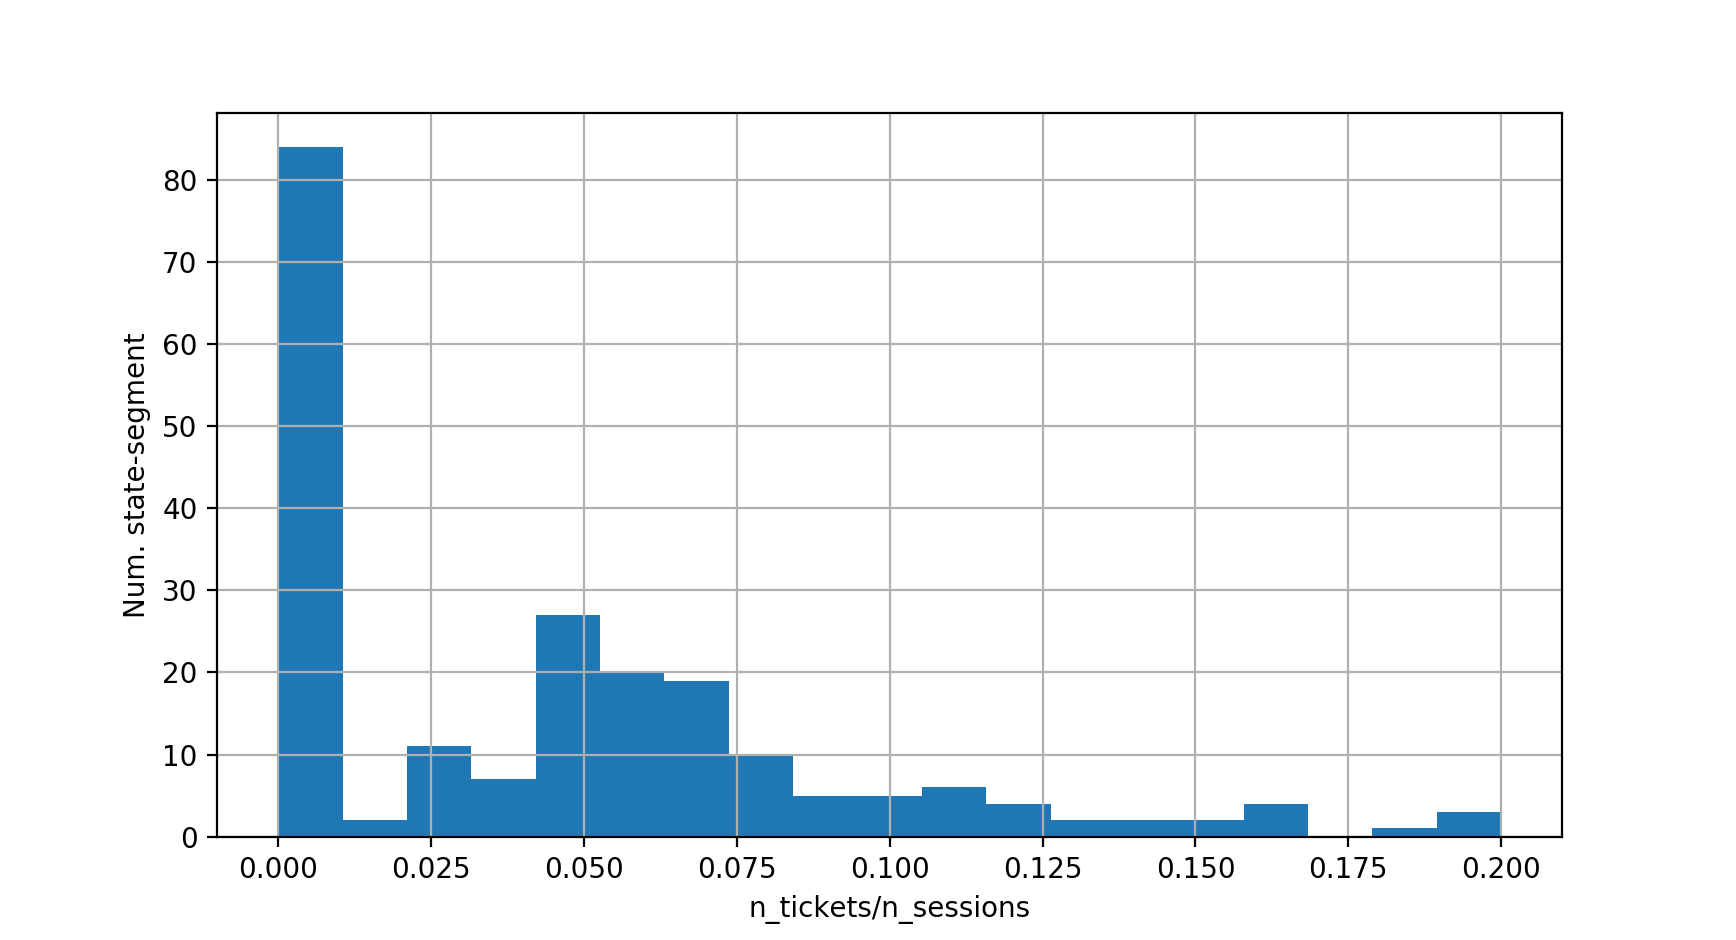

In [330]:
_,ax = plt.subplots();
state_segment.ratio.hist(bins=np.linspace(0,.2,20), ax=ax);
ax.set_xlabel('n_tickets/n_sessions');
ax.set_ylabel('Num. state-segment');

### Similar rates for segments overall

In [123]:
state_segment.groupby('broker_segments').apply(
    lambda x: x['ticket_count_unique'].sum()/x['invoice_sessions_unique'].sum()).sort_values()

broker_segments
Strategic Partner                      0.034810
Agency Network                         0.043233
Small Retail Direct                    0.049918
Small Retail Subproducer (child)       0.059363
Digital                                0.059677
Small Retail Agency Network (child)    0.060029
Wholesale                              0.061624
Large Retail                           0.077897
dtype: float64

### Top 3 segments are ~ 88% tickets

In [128]:
ss_tickets = state_segment.groupby('broker_segments')[
    'ticket_count_unique'].sum().sort_values(ascending=False)

In [131]:
ss_tickets.cumsum()/ss_tickets.sum()

broker_segments
Wholesale                              0.502089
Small Retail Direct                    0.719298
Small Retail Agency Network (child)    0.877193
Small Retail Subproducer (child)       0.963659
Large Retail                           0.980368
Agency Network                         0.989975
Digital                                0.997703
Strategic Partner                      1.000000
Name: ticket_count_unique, dtype: float64

## State

- Top 5(10) states have 80(90)% of tickets and invoice pages visits  
- Top 10 states have 4-7% n_tickets / n_invoice_visits fraction.

In [179]:
import pandas as pd

def mass_density_col(series, cumulative=True, asc=False):
    '''
    Parameters
    ----------
    series (pandas Series): data
    cumulative (bool, optional): Return cumulative mass density (CMD) if True, 
        else probability mass density (PMD), default True. 
    asc (bool, optional): Important for CMD, sort ascending before
        calculating cumulative sum, default False
    
    Returns
    -------
    mass density series, PMD or CMD
    
    '''
    if not isinstance(series, pd.Series):
        raise TypeError('Input pandas Series')
    
    if cumulative:
        return series.sort_values(ascending=asc).cumsum()/series.sum() 
    return series/series.sum()

In [164]:
ss_state = state_segment.groupby('base_state')\
[['invoice_sessions_unique','ticket_count_unique']].sum()
ss_state['ratio'] = ss_state.ticket_count_unique / ss_state.invoice_sessions_unique

#compute average mass density of ticket and invoice session counts
mean_mass_density = ((mass_density_col(ss_state.invoice_sessions_unique, cumulative=False) + \
    mass_density_col(ss_state.ticket_count_unique, cumulative=False))/2).sort_values(ascending=False)
mean_mass_density.name = 'mmd'

#get cumulative mean mass density sort desc
ss_state = ss_state.join(mean_mass_density).sort_values(by='mmd',ascending=False)
ss_state['mmd_cume'] = ss_state.mmd.cumsum()

In [733]:
ss_state.head(10)

invoice_sessions_unique  ticket_count_unique     ratio  \
base_state                                                               
New York                          29345               1570.0  0.053501   
Florida                           17608               1092.0  0.062017   
Texas                             10073                594.0  0.058970   
New Jersey                         4858                295.0  0.060725   
South Carolina                     3781                227.0  0.060037   
California                         3601                210.0  0.058317   
Alabama                            1733                132.0  0.076168   
Georgia                            1578                103.0  0.065272   
Louisiana                          1609                 70.0  0.043505   
North Carolina                     1318                 72.0  0.054628   

                     mmd  mmd_cume  
base_state                          
New York        0.341929  0.341929  
Florida         0.220828  0.562757  
Texas           0.123123  0.685880  
New Jersey      0.060270  0.746150  
South Carolina  0.046637  0.792787  
California      0.043770  0.836557  
Alabama         0.024295  0.860852  
Georgia         0.020327  0.881179  
Louisiana       0.017069  0.898248  
North Carolina  0.015512  0.913760

## Producer Code

In [211]:
from pandas.api.types import CategoricalDtype

In [210]:
nproducers_state_segment = \
df_inv_pol.groupby(['broker_segments', 'base_state'])\
['producer_code'].nunique()\
.to_frame('producer_count').reset_index()

state_segment_producers = nproducers_state_segment.merge(
    ntickets_state_segment, 
    how='left', 
    on=['broker_segments', 'base_state'])\
.fillna(0)

In [215]:
state_segment_producers.head()

broker_segments  base_state  producer_count  ticket_count_unique
0  Agency Network     Arizona               1                  0.0
1  Agency Network  California               1                  5.0
2  Agency Network     Florida               5                 11.0
3  Agency Network    Illinois               1                  1.0
4  Agency Network  New Jersey               1                  1.0

### A few tickets per producer for most state-segment pairs

In [217]:
state_segment_producers['ratio'] = state_segment_producers.ticket_count_unique / \
    state_segment_producers.producer_count

<IPython.core.display.Javascript object>


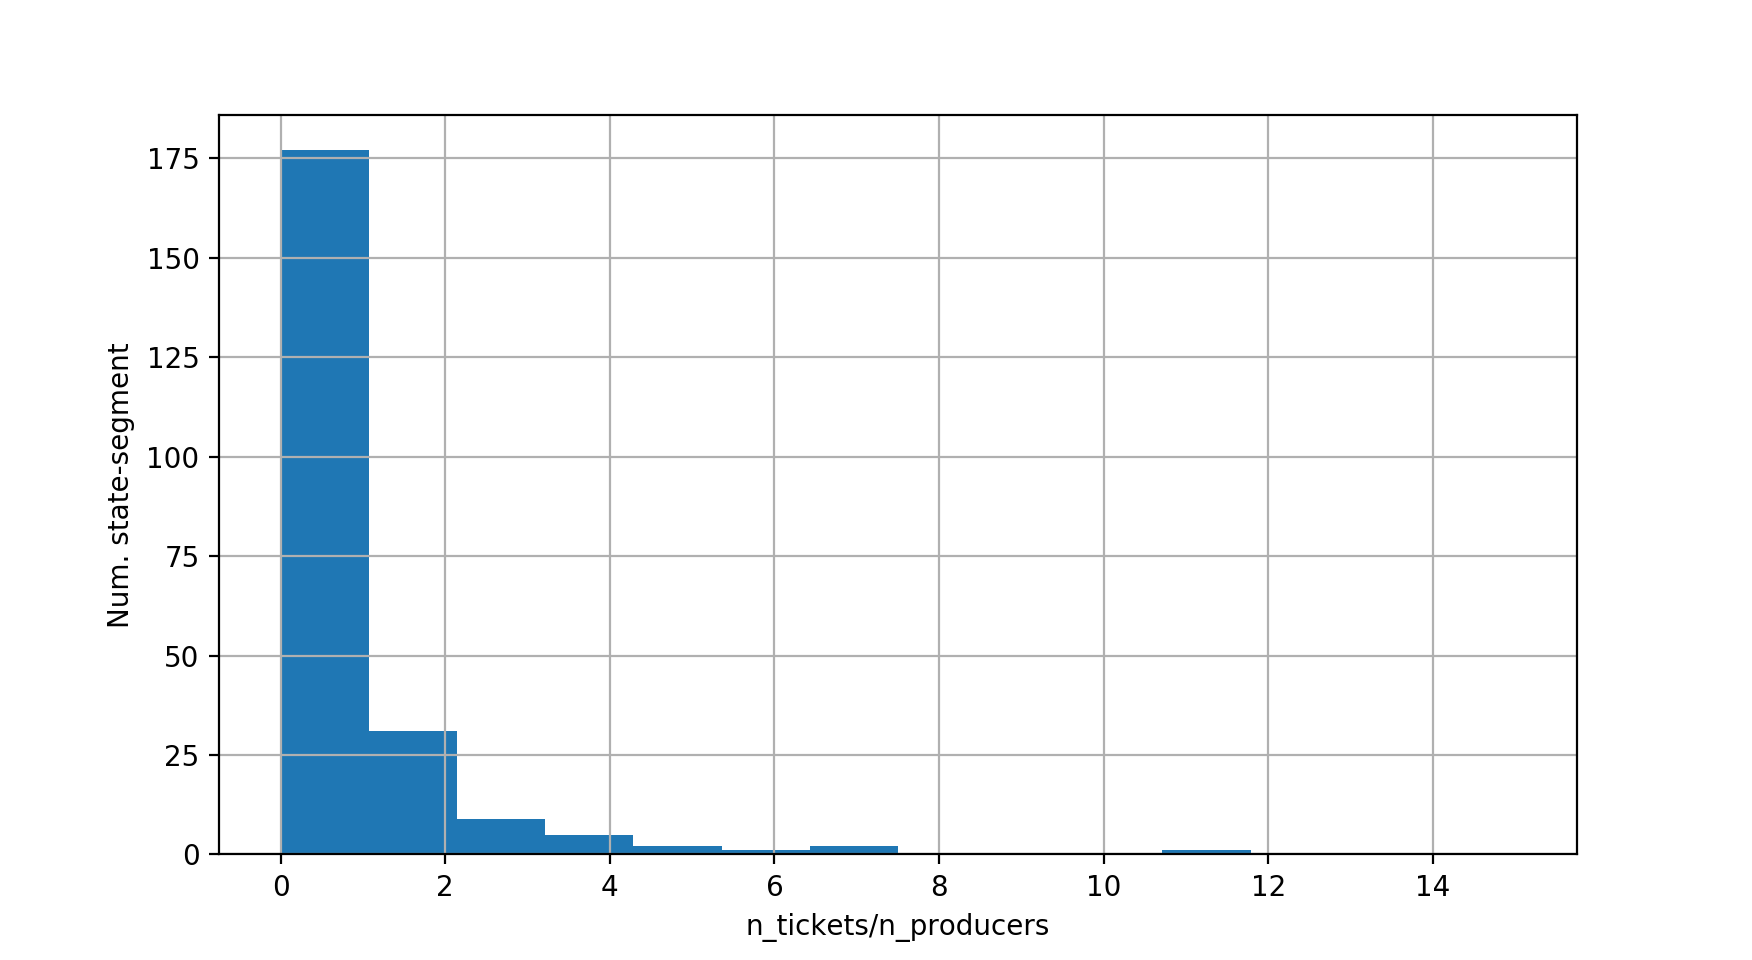

In [331]:
_,ax = plt.subplots();
state_segment_producers.ratio.hist(bins=np.linspace(0,15,15), ax=ax);
ax.set_xlabel('n_tickets/n_producers');
ax.set_ylabel('Num. state-segment');

### 50% of tickets created by top 50 producers

In [243]:
print(f"Num unique producers: {df_matched_tickets.producer_code.nunique()}")

Num unique producers: 1076


In [942]:
df_matched_tickets.groupby('producer_code')['ticket_id'].nunique().sort_values(ascending=False).head(10)

producer_code
MORSTAN00001      323
APPUND0001        268
JOHN00001         256
BTIS00001         182
APPUND0002         94
CMFRST00001        83
BROOKS00001        79
DEMETRIOU00001     66
SCOTT00001         63
SLBINS00001        60
Name: ticket_id, dtype: int64

<IPython.core.display.Javascript object>


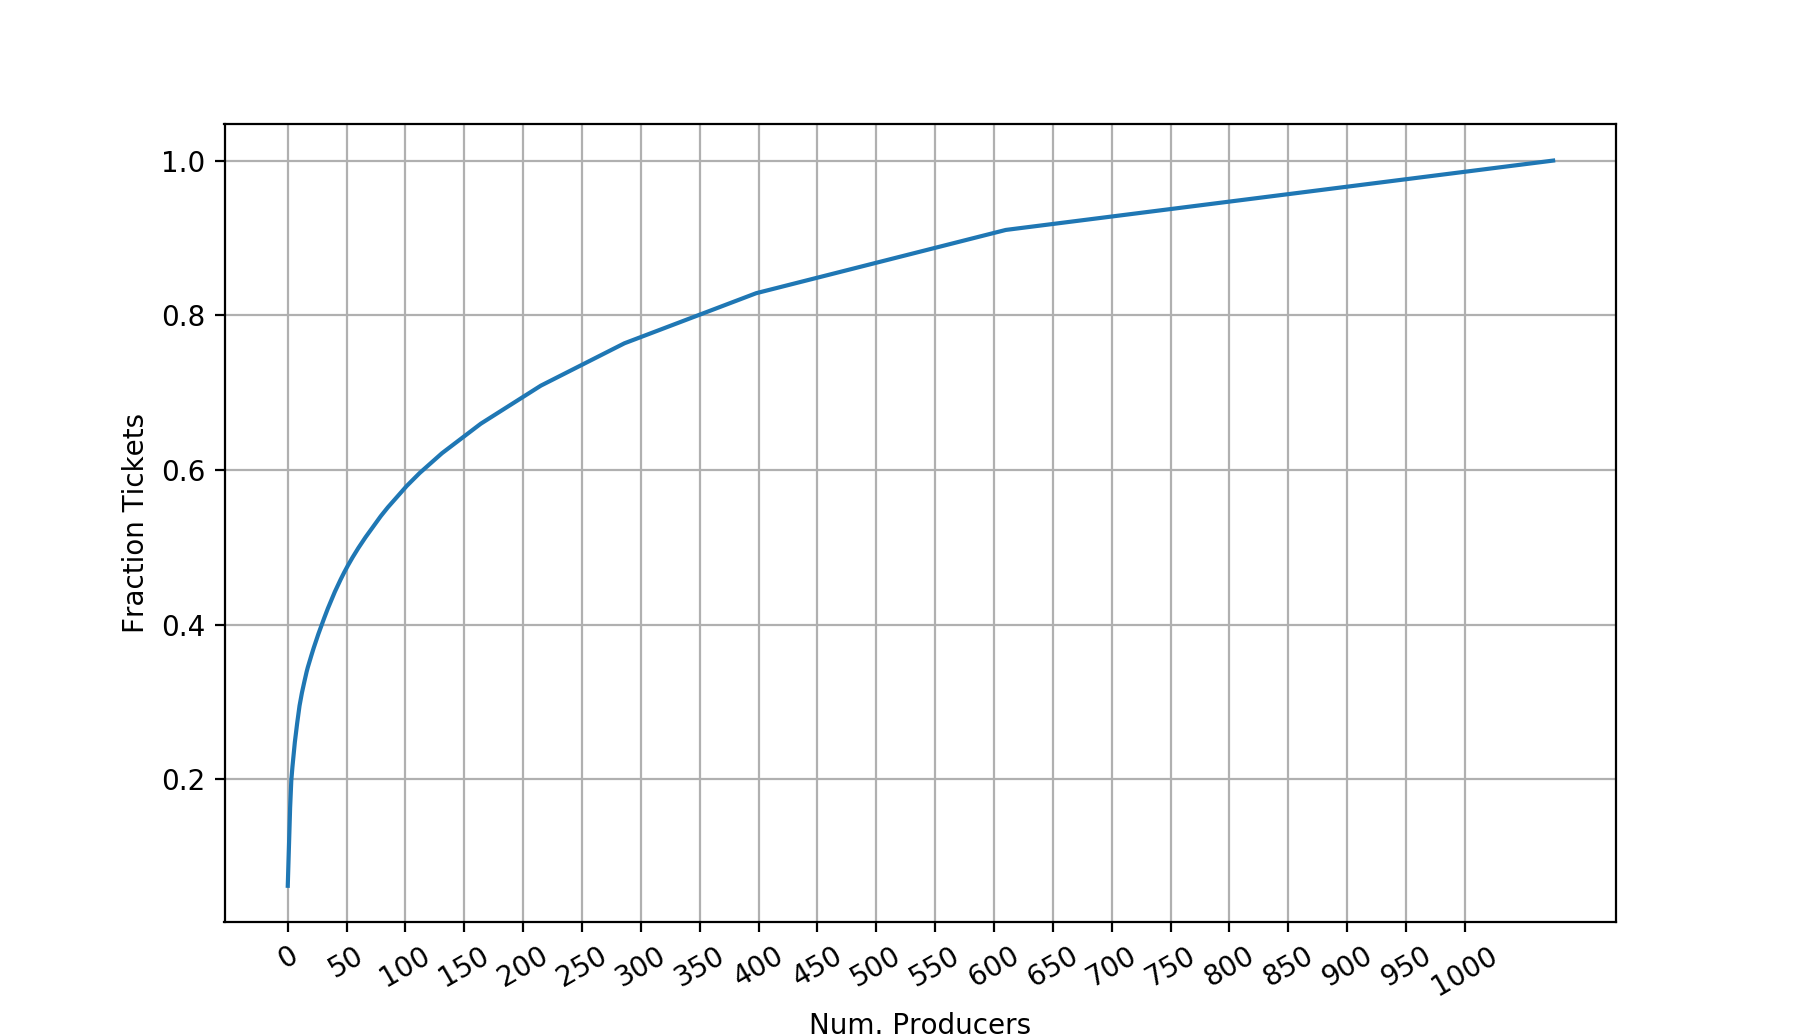

In [298]:
_, ax = plt.subplots();
mass_density_col(df_matched_tickets.groupby('producer_code')[
                 'ticket_id'].nunique()).reset_index().plot(ax=ax,legend=False)

ax.xaxis.set_ticks(np.linspace(0,1000,21));
ax.xaxis.set_tick_params(rotation=30);
ax.grid(which='both');
ax.set_xlabel('Num. Producers');
ax.set_ylabel('Fraction Tickets');

### 3 +/- 2% ticket submission rate for top producers

In [285]:
ip = df_inv_pol.producer_code.value_counts().sort_values(ascending=False).to_frame('n_invoice').reset_index()
tp = df_matched_tickets.producer_code.value_counts().to_frame('n_ticket').reset_index()

In [289]:
pltdf = ip.merge(tp, how='left', on='index').reset_index().drop('index', axis=1).fillna(0)
pltdf['ratio'] = pltdf.n_ticket/pltdf.n_invoice

In [296]:
pltdf[:300].ratio.agg([np.mean, np.std])

mean    0.031880
std     0.022401
Name: ratio, dtype: float64

<IPython.core.display.Javascript object>


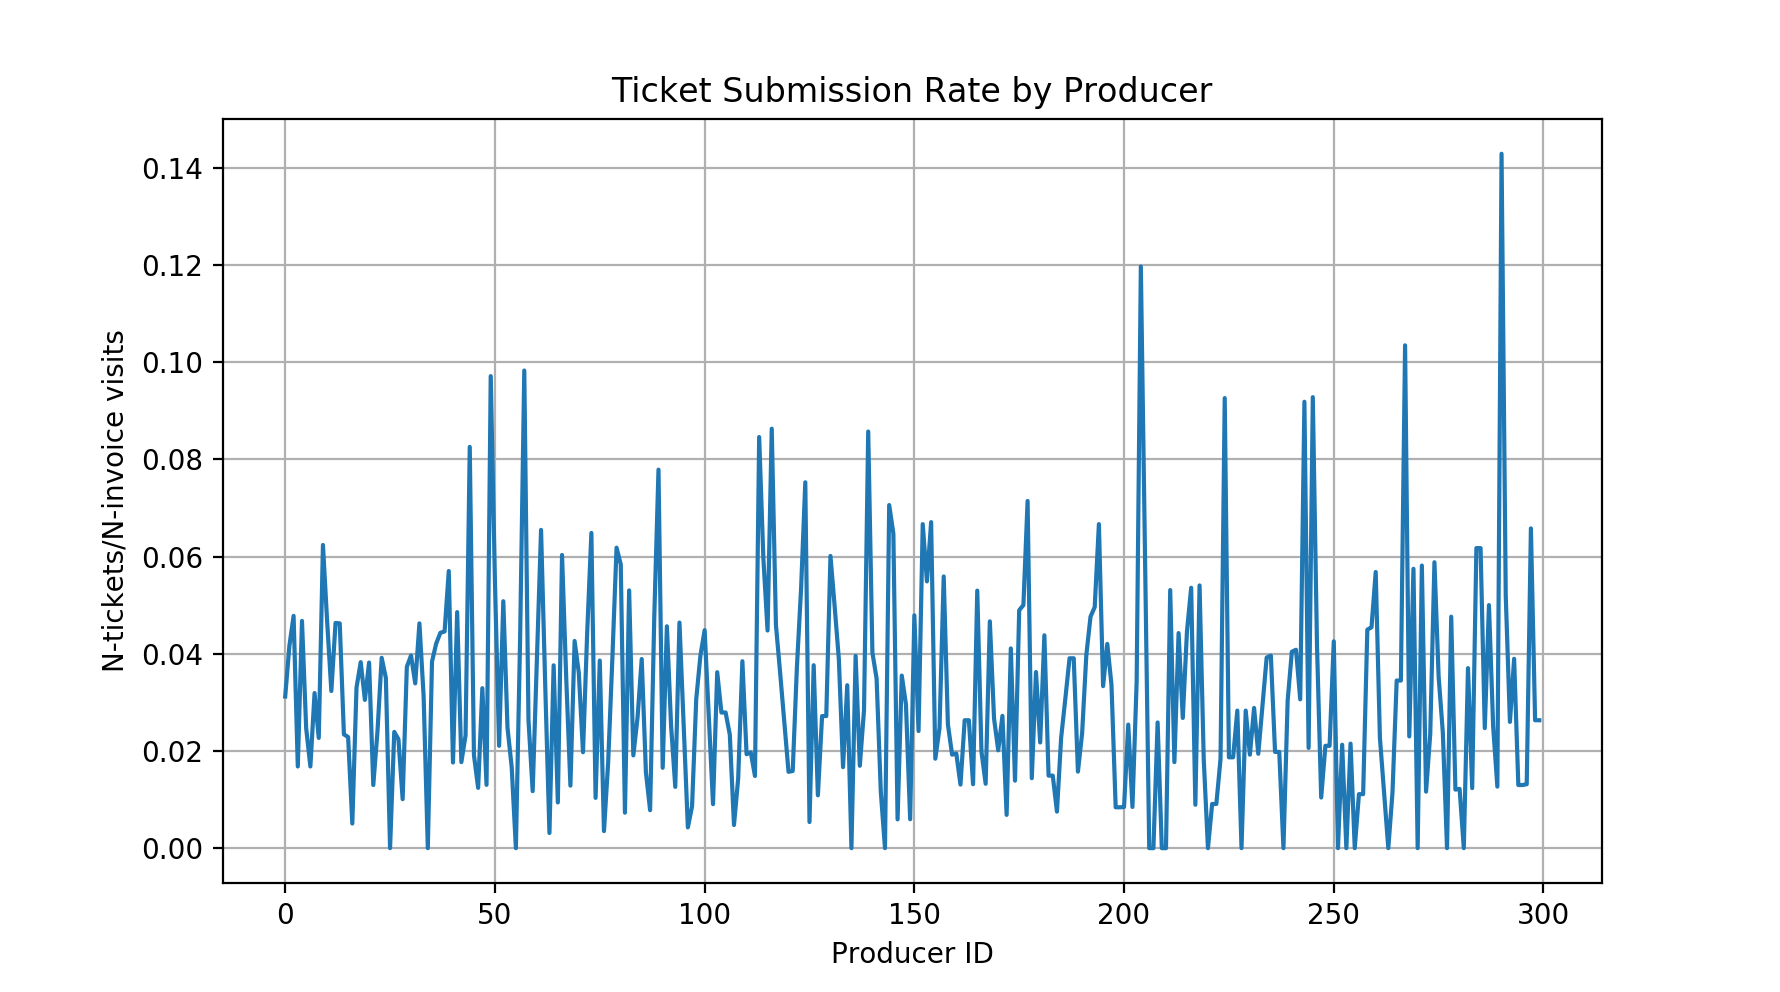

In [297]:
ax = sns.lineplot(data = pltdf[:300],x='level_0',y='ratio');
ax.set_title('Ticket Submission Rate by Producer')
ax.set_xlabel('Producer ID');
ax.set_ylabel('N-tickets/N-invoice visits');
ax.grid();

## Time

In [160]:
date_producer = df_inv_pol.groupby(['day', 'producer_code'])['session_id'].agg(
    n_sessions='nunique').reset_index().merge(
df_matched_tickets.groupby(['day', 'producer_code'])[
    'ticket_id'].agg(n_tickets='nunique').reset_index(),
    on=['day', 'producer_code'], how='left'
).fillna(0)

date_producer['week'] = date_producer.day.map(lambda x: pd.to_datetime(x).week)

<IPython.core.display.Javascript object>


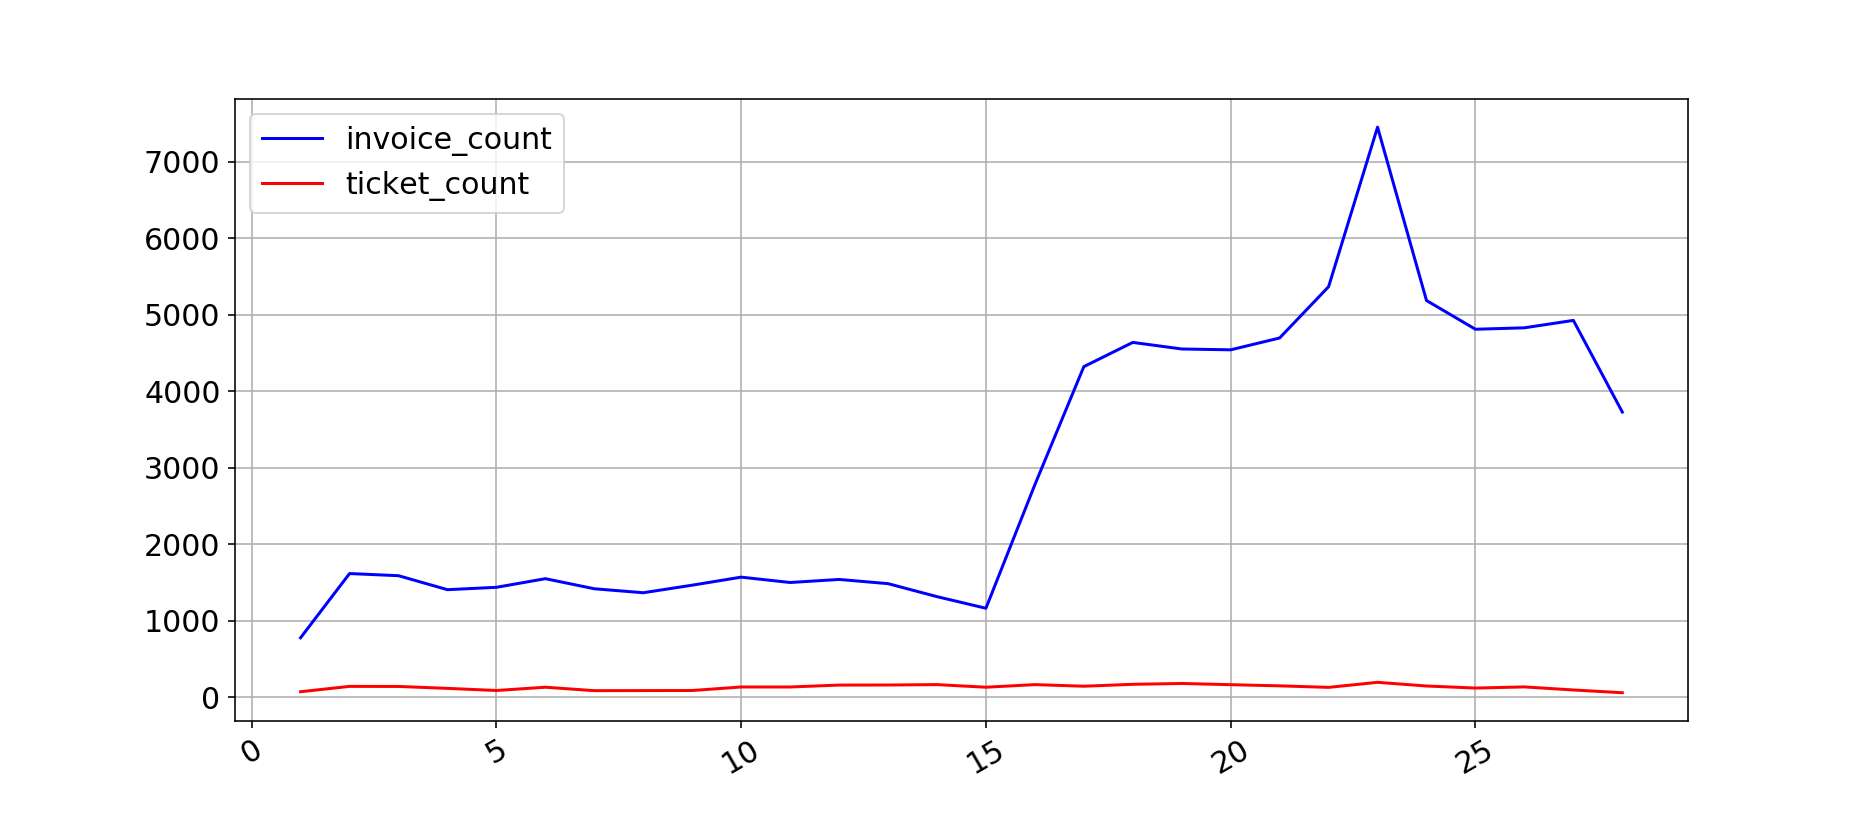

In [886]:
_, ax = plt.subplots()

d = date_producer.groupby('week').sum().reset_index()

ax.plot(d.week.values, d.n_sessions.values,'-b',label='invoice_count')
ax.plot(d.week.values, d.n_tickets.values,'-r',label='ticket_count')
plt.xticks(rotation=30);
ax.legend();
ax.grid();

In [511]:
d['ratio'] = d.n_tickets/d.n_sessions

<IPython.core.display.Javascript object>


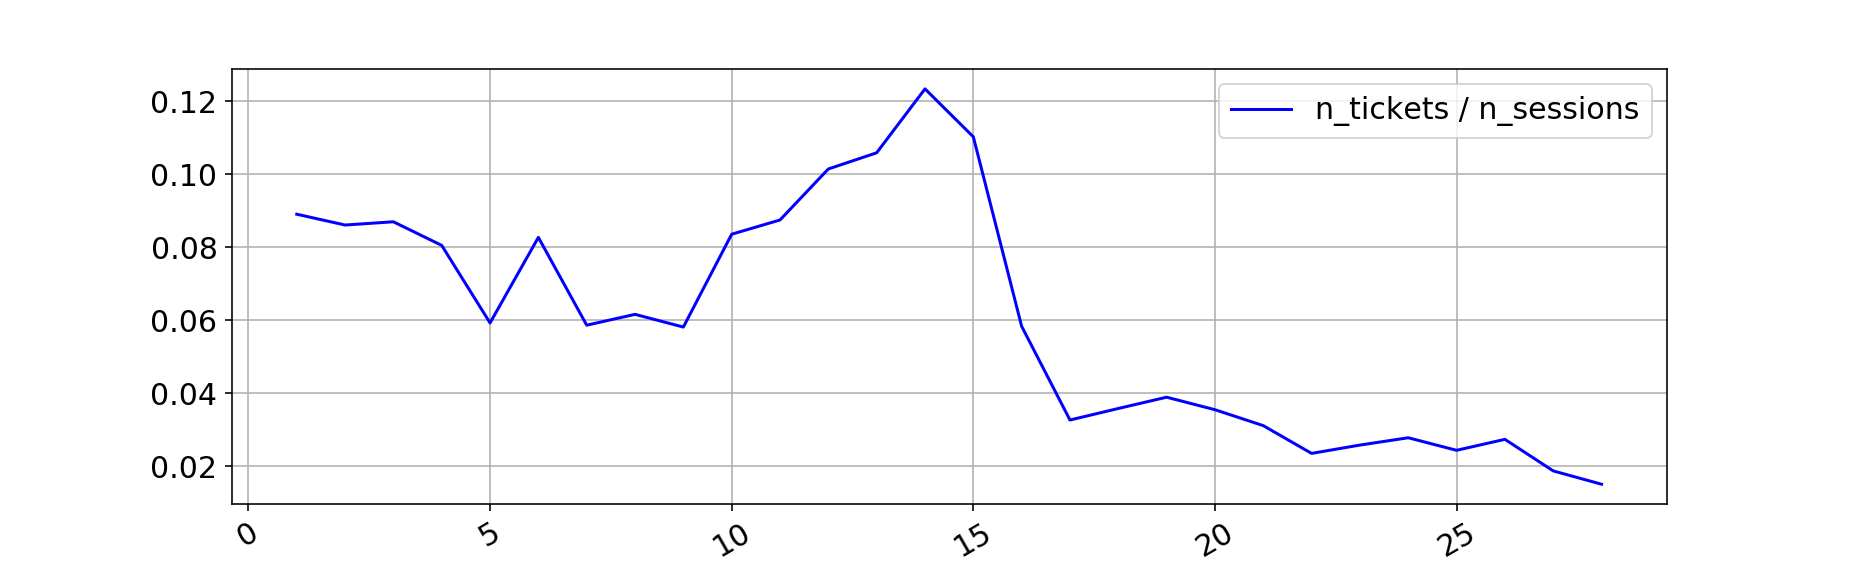

In [512]:
_, ax = plt.subplots()
ax.plot(d.week.values, d.ratio.values,'-b',label='n_tickets / n_sessions')
plt.xticks(rotation=30);
ax.legend();
ax.grid();

### Additional Metrics

Unique producer code visits

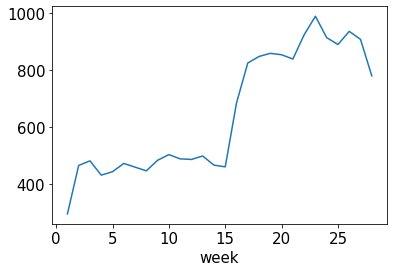

In [928]:
date_producer.groupby('week').apply(lambda x: x['producer_code'].nunique()).plot()

Binary ticket submitted per producer

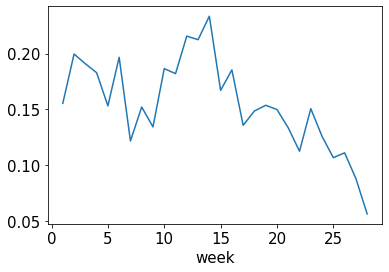

In [934]:
date_producer.groupby('week').apply(lambda x: np.sum(
    x['n_tickets'] > 0)/x['producer_code'].nunique()).plot()

## Set up tests

In [7]:
print(f"Num unique producers that visited invoice page: {df_inv_pol.producer_code.nunique()}")

Num unique producers that visited invoice page: 2167


### Manual test group assignment

In [8]:
top = df_matched_tickets.groupby('producer_code')['ticket_id'].\
nunique().sort_values(ascending=False).head(50).copy()

In [9]:
def pair(series):
    a = series[::2]
    b = series[1::2]
    if a.size>b.size:
        return a, b, a.values[:-1]-b.values
    elif b.size<a.size:
        return a, b, a.values-b.values[:-1]
    return a, b, a.values-b.values

In [10]:
def shuffle(a,b,diff):
    for i,d in enumerate(diff):
        #if you find a producer in a that should move to b
        ind_min = abs(a-d).argmin()
        diff_min = abs(a-d).min()<=5
        if diff_min:
            switch_ind = a.index[ind_min] #producer index
            new_a = a.drop(switch_ind)
            old_b_ind = b.index[i]
            new_b_ind = ','.join([old_b_ind, switch_ind])
            new_b_val = b[old_b_ind] + a[switch_ind]
            new_b = b.drop(old_b_ind)
            new_b[new_b_ind] = new_b_val
            return new_a, new_b, new_a.append(new_b).sort_values(ascending=False)
    else:
        print('No suitable element swap found')
        return a.append(b).sort_values(ascending=False)

In [11]:
a,b,diff = pair(top)
while any(diff>5): 
    shuffled = shuffle(a,b,diff)
    if isinstance(shuffled, tuple):
        a,b,diff = pair(shuffled[2])
        print('Shuffled')
    else:
        break

Shuffled
Shuffled
Shuffled
Shuffled
No suitable element swap found


In [23]:
top_prod_A, top_prod_B, _ = pair(shuffled)

In [235]:
pair(top)

(producer_code
 MORSTAN00001    323
 JOHN00001       256
 APPUND0002       94
 BROOKS00001      79
 SCOTT00001       63
 RPSSI00001       56
 RISKMAG00001     43
 PINKH00001       35
 JLNYG00001       34
 ORCHIA00001      27
 RISKPU00001      26
 JIMCOR00001      25
 LOCMYL00001      24
 INTUAI00001      23
 CNRAGE00001      22
 BRAISH00001      21
 BGG00001         21
 EVRISK00001      20
 SIU00001         19
 REGRIG00001      19
 ROSENZW00001     18
 NEWDFG00001      17
 LONDCUM00001     17
 NEWSAI00001      16
 WWF00001         15
 Name: ticket_id, dtype: int64, producer_code
 APPUND0001        268
 BTIS00001         182
 CMFRST00001        83
 DEMETRIOU00001     66
 SLBINS00001        60
 REGBR00001         43
 LONDONUW00001      37
 NEWAGE00001        35
 UNTC00001          30
 FAIRM00001         26
 SIMONAG00001       26
 MORGEN00001        24
 HULLCOM00001       23
 EMSTBR00001        22
 FTPINC00001        22
 GNP00001           21
 BINDDESK00001      21
 GLOBAL00001        19


In [236]:
pair(shuffled)

(producer_code
 APPUND0001,RPSSI00001         324
 BTIS00001,BROOKS00001         261
 CMFRST00001,NORTHSTAR00001     98
 DEMETRIOU00001                 66
 SLBINS00001                    60
 REGBR00001                     43
 PINKH00001                     35
 JLNYG00001                     34
 ORCHIA00001                    27
 FAIRM00001                     26
 JIMCOR00001                    25
 MORGEN00001                    24
 INTUAI00001                    23
 FTPINC00001                    22
 BINDDESK00001                  21
 BGG00001                       21
 EVRISK00001                    20
 SIU00001                       19
 REGRIG00001                    19
 ROSENZW00001                   18
 BAGASS00001                    17
 NEWSAI00001                    16
 TWFGD00001                     16
 Name: ticket_id, dtype: int64, producer_code
 MORSTAN00001                323
 JOHN00001                   256
 APPUND0002                   94
 SCOTT00001                   63
 R

In [86]:
def split_explode(series, sep=','):
    '''Returns array of exploded strings split by some seperator'''
    return series.str.split(',').explode().values

In [87]:
# split up unique producers to top and not top
top_unq_producers = np.append(split_explode(top_prod_A.reset_index()['producer_code']),
                              split_explode(top_prod_B.reset_index()['producer_code']))
producer_population = df_inv_pol.producer_code.dropna().unique()
bulk_population = np.array(list(set(producer_population).difference(top_unq_producers)))

In [111]:
def make_top_producer_test_groups(top_prod_A, top_prod_B, 
                                  treatment_fraction, verbose=True, random_state=42):
    treatment = top_prod_A.reset_index().sample(frac=treatment_fraction, 
                                                random_state=random_state)
    control = top_prod_B.reset_index().iloc[treatment.index]
    
    treatment_codes = split_explode(treatment['producer_code'])
    control_codes = split_explode(control['producer_code'])
    
    if verbose:
        print(f"Sampling Top Producers.....")
        print(f"Treatment fraction: {treatment_fraction}")
        print(f"Treatment Group Size: {treatment_codes.size}")
        print(f"Control Group Size: {control_codes.size}")
        print("")
    return control_codes, treatment_codes

In [170]:
def make_test_groups(test_fraction, population_series, 
                     verbose=True, random_state=42, fix_test_state=False):
    
    #keep test sample random state fixed, but vary random state of treatment vs control
    if fix_test_state:
        test_random_state = 99999
    else:
        test_random_state = random_state
    
    test_sample = population_series.sample(frac=test_fraction, random_state=test_random_state)
    treatment = test_sample.sample(frac=.50, random_state=random_state).values
    control = test_sample[~test_sample.isin(treatment)].values
    
    if verbose:
        print("Sampling bulk...")
        print(f"Test fraction: {test_fraction}")
        print(f"Num unique population elements: {population_series.nunique()}")
        print(f"Test Group Size: {test_sample.size}")
        print(f"Test Random State: {test_random_state}")
        print(f"Control/Treatment Random State: {random_state}")
        print(f"Control Group Size: {control.size}")
        print(f"Treatment Group Size: {treatment.size}")
        print("")
        
    return control, treatment

In [169]:
def combine_test_groups(top_prod_A, top_prod_B, bulk_producers,
                        test_fraction, verbose=True, random_state=42, fix_test_state=False):
    
    #top producers
    treatment_fraction = test_fraction / 2
    top_control, top_treatment = make_top_producer_test_groups(top_prod_A, top_prod_B, 
                                  treatment_fraction, verbose=verbose, random_state=random_state)
    
    #bulk producers
    bulk_control, bulk_treatment = make_test_groups(test_fraction, pd.Series(bulk_producers), 
                                                 verbose=verbose, random_state=random_state, 
                                                 fix_test_state=fix_test_state)
    
    final_control = np.append(top_control, bulk_control)
    assert np.unique(final_control).size == final_control.size
    final_treatment = np.append(top_treatment, bulk_treatment)
    assert np.unique(final_treatment).size == final_treatment.size
    
    if verbose:
        print(f"Combining results.....")
        total_producers = bulk_producers.size + top_prod_A.size + top_prod_B.size
        print(f"Total Num. Producers: {total_producers}")
        print(f"Test fraction requested: {test_fraction}")
        test_grp_size = top_control.size + bulk_control.size + \
        top_treatment.size + bulk_treatment.size
        print(f"Test Group Size: {test_grp_size}")
        print(f"Test fraction actual: {(test_grp_size/ total_producers):.3f}")
        print("")   
        print(f"Treatment(Control) fraction requested: {(test_fraction/2):.3f}")
        treat_grp_size = top_treatment.size + bulk_treatment.size
        control_grp_size = top_control.size + bulk_control.size
        print(f"Treatment(Control) Group Size: {treat_grp_size:}({control_grp_size:})")
        print(f"Treatment(Control) fraction actual: {(treat_grp_size/ total_producers):.3f}({(control_grp_size/ total_producers):.3f})")
        
    return final_control, final_treatment

#### Sample experiment (manual assignment)

In [192]:
control_codes, treatment_codes = combine_test_groups(top_prod_A,top_prod_B,bulk_population,.4,
                    verbose=True,random_state=40,fix_test_state=True)

Sampling Top Producers.....
Treatment fraction: 0.2
Treatment Group Size: 5
Control Group Size: 6

Sampling bulk...
Test fraction: 0.4
Num unique population elements: 2117
Test Group Size: 847
Test Random State: 99999
Control/Treatment Random State: 40
Control Group Size: 423
Treatment Group Size: 424

Combining results.....
Total Num. Producers: 2163
Test fraction requested: 0.4
Test Group Size: 858
Test fraction actual: 0.397

Treatment(Control) fraction requested: 0.200
Treatment(Control) Group Size: 429(429)
Treatment(Control) fraction actual: 0.198(0.198)


In [193]:
calc_effect(control_codes, treatment_codes, freq='week').head(3)

week  n_sessions_c  n_tickets_c  run_sessions_c  run_tickets_c  \
0     1           106          9.0             106            9.0   
1     2           189         12.0             295           21.0   
2     3           216         13.0             511           34.0   

   conversion_c  n_sessions_t  n_tickets_t  run_sessions_t  run_tickets_t  \
0      0.084906           100          7.0             100            7.0   
1      0.071186           187          8.0             287           15.0   
2      0.066536           205          9.0             492           24.0   

   conversion_t  treatment_effect  
0      0.070000         -0.175556  
1      0.052265         -0.265804  
2      0.048780         -0.266858

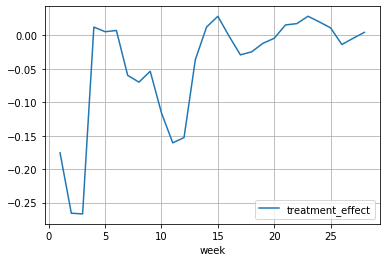

In [194]:
calc_effect(control_codes, treatment_codes, freq='week').plot(x='week',y='treatment_effect',grid=True)

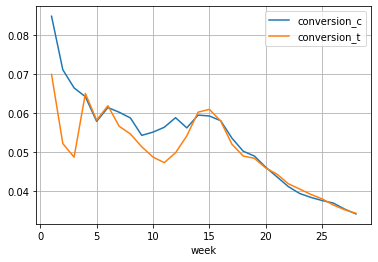

In [195]:
calc_effect(control_codes, treatment_codes, freq='week').plot(
    x='week', y=['conversion_c', 'conversion_t'], grid=True)

#### Run A/A Experiments

In [225]:
freq='week'
num_exp = 100
results = np.empty((num_exp,date_producer[freq].nunique(),3))
for i in range(num_exp):
    control_codes, treatment_codes = combine_test_groups(top_prod_A,top_prod_B,bulk_population,.4,
                    verbose=False,random_state=i,fix_test_state=False)
    results[i] = (calc_effect(control_codes, treatment_codes, freq=freq)[
                   ['run_sessions_t', 'run_tickets_t', 'treatment_effect']].to_numpy())

In [226]:
d1, d2, d3 = results.shape
print(f"Ran {d1} experiments, {d2} {freq}s each.")

Ran 100 experiments, 28 weeks each.


In [227]:
@iw.interact(n_inv_samples=(500, 25000, 500))
def plot_samp_dist(n_inv_samples=500):
    res = calc_ref_sampling_distribution(results, n_inv_samples)
    print(f"{n_inv_samples} per exp requested.")
    print(f"Got {np.nanmean(res[1]):.1f} +/- {np.nanstd(res[1]):.1f} after {np.nanmean(res[0]):.1f} +/- {np.nanstd(res[0]):.1f} {freq}s")
    print(f"Treatment Effect: mean={np.mean(res[2]):.2f}, sig={np.std(res[2]):.2f}, 2sig={2*np.std(res[2]):.2f}")
    ax = sns.distplot(res[2], bins=np.linspace(-1, 1, 50));
    ax.grid();

interactive(children=(IntSlider(value=500, description='n_inv_samples', max=25000, min=500, step=500), Output(…

#### Final codes

In [199]:
control_codes, treatment_codes = combine_test_groups(top_prod_A,top_prod_B,bulk_population,.4,
                    verbose=True,random_state=42,fix_test_state=False)

Sampling Top Producers.....
Treatment fraction: 0.2
Treatment Group Size: 6
Control Group Size: 5

Sampling bulk...
Test fraction: 0.4
Num unique population elements: 2117
Test Group Size: 847
Test Random State: 42
Control/Treatment Random State: 42
Control Group Size: 423
Treatment Group Size: 424

Combining results.....
Total Num. Producers: 2163
Test fraction requested: 0.4
Test Group Size: 858
Test fraction actual: 0.397

Treatment(Control) fraction requested: 0.200
Treatment(Control) Group Size: 430(428)
Treatment(Control) fraction actual: 0.199(0.198)


2020-07-20 14:57:12 

In [207]:
control_codes.tofile('control_producer_codes.txt', sep=",")

In [208]:
treatment_codes.tofile('treatment_producer_codes.txt', sep=",")

### Random sample of producers per test group

#### Sample Experiment (random sampling)

In [902]:
control_codes, treatment_codes = make_test_groups(0.43, 
                                                  pd.Series(df_inv_pol.producer_code.unique()),
                                                 random_state=42)

Test fraction: 0.43
Num unique population elements: 2167
Test Group Size: 932
Test Random State: 99999
Control/Treatment Random State: 42
Control Group Size: 466
Treatment Group Size: 466


In [155]:
def calc_conversion(mask_ids, freq='day'):
    '''global date_producer DF'''
    df = date_producer[date_producer.producer_code.isin(mask_ids)].\
    groupby(freq).sum().reset_index()
    df['run_sessions'] = df['n_sessions'].cumsum()
    df['run_tickets'] = df['n_tickets'].cumsum()
    df['conversion'] = df['run_tickets'] / df['run_sessions']
    return df

In [156]:
def calc_effect(control_codes, treatment_codes, freq='day'):
    merged = calc_conversion(control_codes, freq=freq).merge(
        calc_conversion(treatment_codes, freq=freq), 
        on=freq, 
        how='outer',
        suffixes=('_c', '_t'))
    merged['treatment_effect'] = (merged['conversion_t']/merged['conversion_c'] - 1).fillna(0)
    return merged.replace({np.inf:0})

Look at treatment effect over time - why to not stop early 
[(Airbnb Experiments)](https://medium.com/airbnb-engineering/experiments-at-airbnb-e2db3abf39e7)

In [701]:
calc_effect(control_codes, treatment_codes, freq='week').head(3)

week  n_sessions_c  n_tickets_c  run_sessions_c  run_tickets_c  \
0     1           232         23.0             232           23.0   
1     2           496         46.0             728           69.0   
2     3           493         41.0            1221          110.0   

   conversion_c  n_sessions_t  n_tickets_t  run_sessions_t  run_tickets_t  \
0      0.099138           128         14.0             128           14.0   
1      0.094780           244         19.0             372           33.0   
2      0.090090           249         20.0             621           53.0   

   conversion_t  treatment_effect  
0      0.109375          0.103261  
1      0.088710         -0.064049  
2      0.085346         -0.052657

<IPython.core.display.Javascript object>


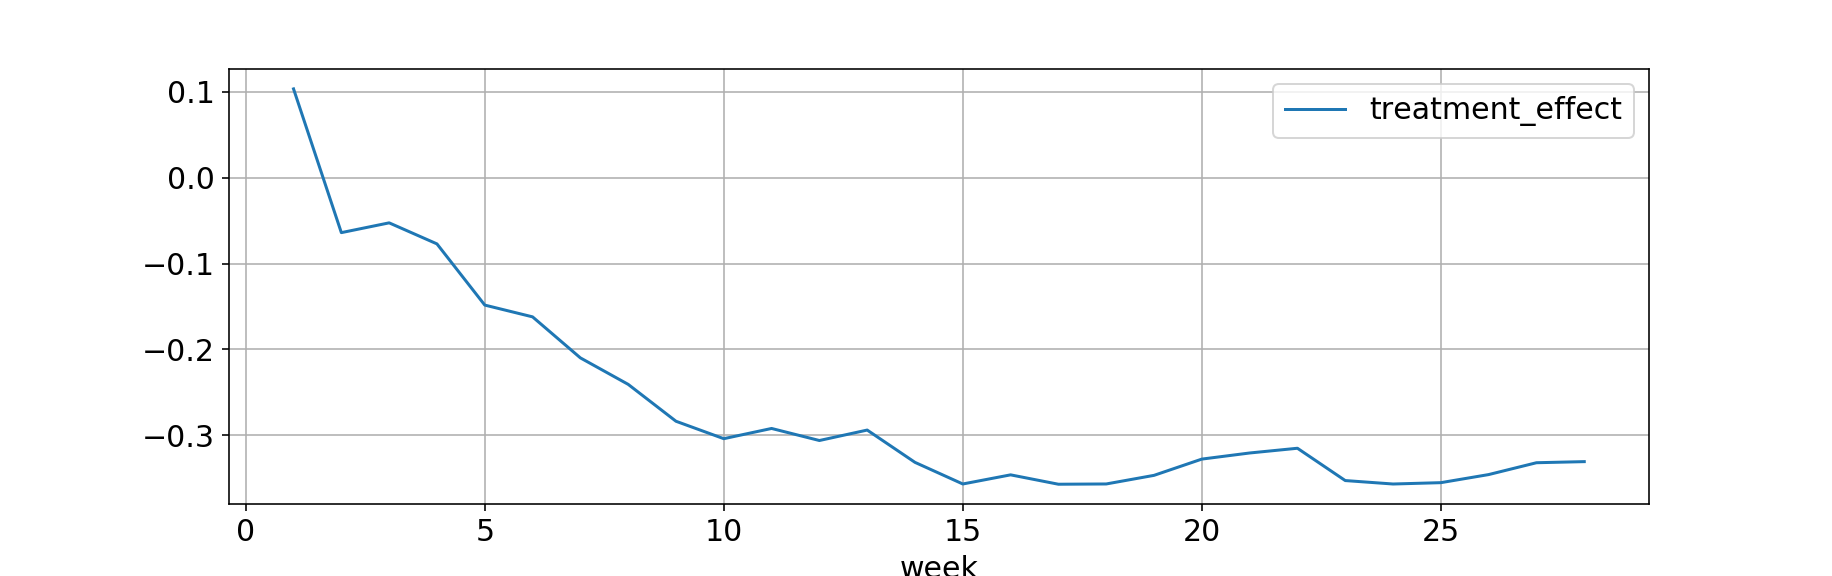

In [710]:
calc_effect(control_codes, treatment_codes, freq='week').plot(x='week',y='treatment_effect',grid=True)

<IPython.core.display.Javascript object>


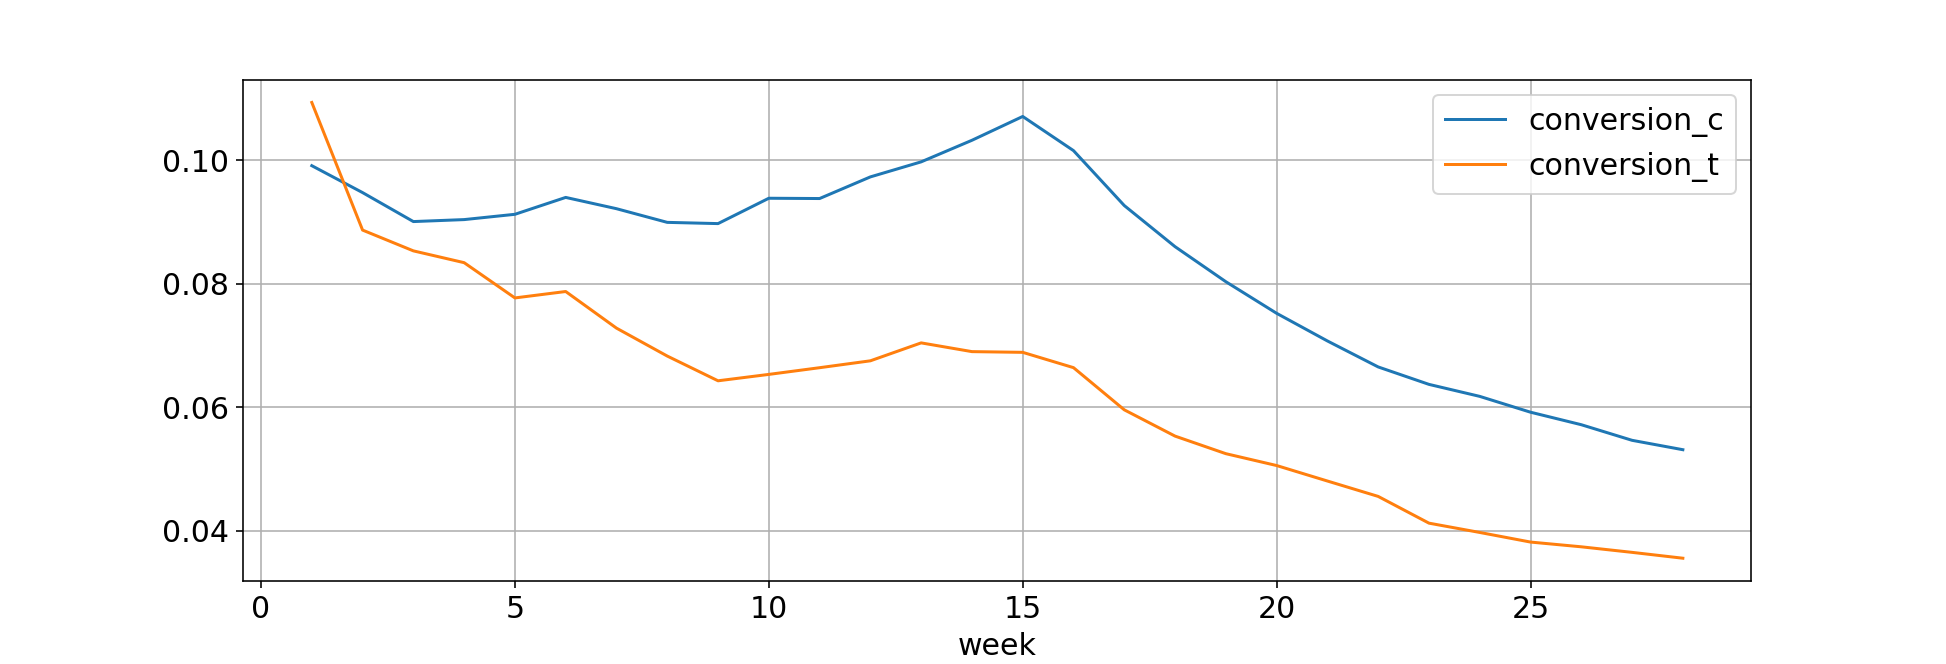

In [713]:
calc_effect(control_codes, treatment_codes, freq='week').plot(
    x='week', y=['conversion_c', 'conversion_t'], grid=True)

#### Run A/A Experiments

In [209]:
freq='week'
num_exp = 100
results = np.empty((num_exp,date_producer[freq].nunique(),3))
for i in range(num_exp):
    control_codes, treatment_codes = make_test_groups(
        0.43, pd.Series(df_inv_pol.producer_code.unique()), verbose=False, random_state=i)
    results[i] = (calc_effect(control_codes, treatment_codes, freq=freq)[
                   ['run_sessions_t', 'run_tickets_t', 'treatment_effect']].to_numpy())

In [210]:
d1, d2, d3 = results.shape
print(f"Ran {d1} experiments, {d2} {freq}s each.")

Ran 100 experiments, 28 weeks each.


In [211]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

In [212]:
def calc_ref_sampling_distribution(results, n_invoice_visits=500):
    inds = np.apply_along_axis(lambda x: find_nearest(x,n_invoice_visits), 1, results[:,:,0])
    data = np.array([results[i,idx,:] for i, idx in enumerate(inds)])
    invoice_dist = data[:,0]
    treatment_dist = data[:,2]
    return inds, invoice_dist, treatment_dist

In [213]:
from scipy.stats import zscore
import ipywidgets as iw

In [214]:
@iw.interact(n_inv_samples=(500, 25000, 500))
def plot_samp_dist(n_inv_samples=500):
    res = calc_ref_sampling_distribution(results, n_inv_samples)
    print(f"{n_inv_samples} per exp requested.")
    print(f"Got {np.nanmean(res[1]):.1f} +/- {np.nanstd(res[1]):.1f} after {np.nanmean(res[0]):.1f} +/- {np.nanstd(res[0]):.1f} {freq}s")
    print(f"Treatment Effect: mean={np.mean(res[2]):.2f}, sig={np.std(res[2]):.2f}, 2sig={2*np.std(res[2]):.2f}")
    ax = sns.distplot(res[2], bins=np.linspace(-1, 1, 50));
    ax.grid();

interactive(children=(IntSlider(value=500, description='n_inv_samples', max=25000, min=500, step=500), Output(…

### Stratified by Broker Segment Sample

In [215]:
#mask to remove state-segment pairs with 0-2 producers
stratify_mask = df_inv_pol.groupby(['base_state', 'broker_segments'])['producer_code'].apply(
    lambda x: x.unique().size>2).reset_index().producer_code

In [216]:
strat_prod = df_inv_pol.groupby(['base_state', 'broker_segments'])['producer_code'].apply(
    lambda x: x.unique()).reset_index()

In [217]:
strat_broker = df_inv_pol.groupby(['broker_segments'])['producer_code'].apply(
    lambda x: x.unique()).reset_index()

In [218]:
# strat_prod[stratify_mask].head()
df_inv_pol.groupby(['broker_segments'])['producer_code'].apply(
    lambda x: x.unique().size).reset_index()

broker_segments  producer_code
0                       Agency Network             15
1                              Digital              3
2                         Large Retail             47
3  Small Retail Agency Network (child)            808
4                  Small Retail Direct            799
5     Small Retail Subproducer (child)            326
6                    Strategic Partner              5
7                            Wholesale            156

In [219]:
def strat_sample(producers, test_fraction, random_state=42):
    if test_fraction*len(producers)<2:
        test_sample = np.random.choice(producers, 2, replace=False)
        control = test_sample[0]
        treatment = test_sample[1]
    else:
        test_sample = pd.Series(producers).sample(frac=test_fraction, random_state=999999)
        treatment = test_sample.sample(frac=.50, random_state=random_state).values
        control = test_sample[~test_sample.isin(treatment)].values
    return {"control": control, "treatment": treatment}

In [220]:
def make_strat_test_groups(test_fraction, strat_pop_df, sample_size_mask=None, verbose=True, random_state=42):
    
    if sample_size_mask:
        #large sample sizes
        test_large = strat_pop_df[sample_size_mask]['producer_code'].apply(
        lambda x: strat_sample(x, test_fraction, random_state=random_state))

        control_large = test_large.map(lambda x: (x['control'])).explode().unique()
        treatment_large = test_large.map(lambda x: (x['treatment'])).explode().unique()

#         print(len(set(control_large).intersection(treatment_large)))

        #small sample sizes
        test_small = pd.Series(strat_pop_df[~sample_size_mask]['producer_code'].explode().unique()).\
        sample(frac=test_fraction, random_state=random_state)

        treatment_small = test_small.sample(frac=.50, random_state=random_state).values
        control_small = test_small[~test_small.isin(treatment_small)].values

        #merge
        control = np.append(control_large, control_small)
        treatment = np.append(treatment_large, treatment_small)
        
        if verbose:
            print("Mask Applied-----")
            print(f"Test fraction requested: {test_fraction}")
            nup = strat_pop_df.producer_code.explode().nunique()
            print(f"Num unique population elements: {nup}")
            print(f"Test Group Size: {control_large.size + treatment_large.size + test_small.size}")
            print(f"Control Group Size: {control.size}")
            ts = treatment.size
            print(f"Treatment Group Size: {ts}")
            print(f"Treatment Group Actual Fraction: {ts/nup:.2f}")
        
    else:
        test = strat_pop_df['producer_code'].apply(
        lambda x: strat_sample(x, test_fraction, random_state=random_state))

        control = test.map(lambda x: (x['control'])).explode().unique()
        treatment = test.map(lambda x: (x['treatment'])).explode().unique()

#         print(len(set(control).intersection(treatment)))
        
        if verbose:
            print("No Mask Applied-----")
            print(f"Test fraction requested: {test_fraction}")
            nup = strat_pop_df.producer_code.explode().nunique()
            print(f"Num unique population elements: {nup}")
            print(f"Test Group Size: {control.size + treatment.size}")
            print(f"Control Group Size: {control.size}")
            ts = treatment.size
            print(f"Treatment Group Size: {ts}")
            print(f"Treatment Group Actual Fraction: {ts/nup:.2f}")
    
    

    return control, treatment

In [221]:
control, treatment = make_strat_test_groups(
    .43, strat_broker, None, verbose=True, random_state=42)

No Mask Applied-----
Test fraction requested: 0.43
Num unique population elements: 2159
Test Group Size: 928
Control Group Size: 463
Treatment Group Size: 465
Treatment Group Actual Fraction: 0.22


In [878]:
treatment_codes

array(['CAPMAR00001', 'AIDMYAPPSIL00001', 'TWFGD00001', 'BININS0001',
       'MMAVER00001', 'BRBSA00001', 'BRBCC00001', 'HUBGULSOU00001',
       'NEWTEK00001', 'MMAHP00001', 'BRBLA0001', 'BRBFDI00001',
       'BXSHOU00001', 'BRUGND0001', 'APPROB00001', 'SIANFBI00001',
       'FLSMAPTCGI1', 'IRQFCIC00001', 'SIASFGO00001', 'SIAAAPI00001',
       'INTFGABDUL00001', 'FCOELMINS00001', 'SIAAIAIN00001',
       'SIAMDB00001', 'NJSMASECIOATLS1', 'IMSBRG001', 'LASMABAIS1',
       'ADPAPEAL00001', 'IRQPRO00001', 'EVOMSAL00001', 'INTCEDAR00001',
       'LASMAPF1', 'ADPBIB00001', 'ETON00001', 'RENMIFG00001',
       'FLIMSSTR1', 'JHCINS00001', 'SIACIG00001', 'SIANFDM00001',
       'FLIMSBPF1', 'LAIMSDJW1', 'NYSMAGMINSBROK1', 'TMKKALL00001',
       'TXSMATI1', 'LAIMSCIS1', 'GASMAGOLKEYINS1', 'APPJEFF00001',
       'UNINACV00001', 'FLIMSHERB1', 'PACDYOUNG00001', 'SELLOU00001',
       'FCAIA00001', 'FLIMSMAD1', 'ADPAUROC00001', 'SPIPAGE00001',
       'SIASAFIKW00001', 'MORGAN00001', 'FLIMSAB1', 'SIAMCW

#### Run A/A Experiments

In [222]:
freq='week'
num_exp = 100
results = np.empty((num_exp,date_producer[freq].nunique(),3))
for i in range(num_exp):
    control_codes, treatment_codes = \
    make_strat_test_groups(.43, strat_broker, None, verbose=False, random_state=i)
    results[i] = (calc_effect(control_codes, treatment_codes, freq=freq)[
                   ['run_sessions_t', 'run_tickets_t', 'treatment_effect']].to_numpy())

In [223]:
d1, d2, d3 = results.shape
print(f"Ran {d1} experiments, {d2} {freq}s each.")

Ran 100 experiments, 28 weeks each.


In [224]:
@iw.interact(n_inv_samples=(500, 25000, 500))
def plot_samp_dist(n_inv_samples=500):
    res = calc_ref_sampling_distribution(results, n_inv_samples)
    print(f"{n_inv_samples} per exp requested.")
    print(f"Got {np.nanmean(res[1]):.1f} +/- {np.nanstd(res[1]):.1f} after {np.nanmean(res[0]):.1f} +/- {np.nanstd(res[0]):.1f} {freq}s")
    print(f"Treatment Effect: mean={np.mean(res[2]):.2f}, sig={np.std(res[2]):.2f}, 2sig={2*np.std(res[2]):.2f}")
    ax = sns.distplot(res[2], bins=np.linspace(-1, 1, 50));
    ax.grid();

interactive(children=(IntSlider(value=500, description='n_inv_samples', max=25000, min=500, step=500), Output(…